In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning removal
warnings.simplefilter(action='ignore', category=RuntimeWarning) # FutureWarning removal

In [2]:
dir = './data/'
seasons = ['spring','summer','fall','winter']
site_files = {season: sorted(glob.glob(dir + f'*PCA_ALL_{season}_5dys.csv')) for season in seasons}


In [24]:
from scipy import stats

dir        = './data/'
dir_site   = '/glade/derecho/scratch/sungyoon/data/FLUXNET/FULLSET/'
# dir_site   = '/projects/COLA/land/skim/FLUXNET/FULLSET/'

site_files = {season: sorted(glob.glob(dir + f'*PCA_ALL_{season}_5dys.csv')) for season in seasons}
pca_data   = {season: {'pc1' : pd.DataFrame(columns=['SiteID','all_swc','all_le','all_h','all_rad']),
                       'pc2' : pd.DataFrame(columns=['SiteID','all_swc','all_le','all_h','all_rad'])
                       } for season in seasons}

date = 'Unnamed: 0'
for season in seasons:
    for site in site_files[season][:]:  # Limit to first 2 files for now (adjust as needed)
        f_siteid = site.split("/")[-1].split("_")[0]  # Adjust based on actual file structure

        # Read data
        df1 = pd.read_csv(dir + f_siteid + f'_PCA_ALL_{season}_5dys.csv', na_values=-9999)
        df2 = pd.read_csv(dir + f_siteid + f'_PCA_NoSWC_{season}_5dys.csv', na_values=-9999)
        df3 = pd.read_csv(dir + f_siteid + f'_PCA_NoLE_{season}_5dys.csv', na_values=-9999)
        df4 = pd.read_csv(dir + f_siteid + f'_PCA_NoH_{season}_5dys.csv', na_values=-9999)
        df5 = pd.read_csv(dir + f_siteid + f'_PCA_NoRAD_{season}_5dys.csv', na_values=-9999)

        df_site = pd.read_csv((dir_site+f_siteid+'_site.csv'),sep=',')    
        lat     = df_site['Latitude'].item()
        
        if (lat > 0.):
            season_months = {seasons[0]: ['03', '04', '05'],
                             seasons[1]: ['06', '07', '08'],
                             seasons[2]: ['09', '10', '11'],
                             seasons[3]: ['12', '01', '02']}
        else:
            season_months = {seasons[0]: ['09', '10', '11'],
                             seasons[1]: ['12', '01', '02'],
                             seasons[2]: ['03', '04', '05'],
                             seasons[3]: ['06', '07', '08']}
                
        for df in [df1,df2,df3,df4,df5]:
            df[date] = pd.to_datetime(df[date])
        years =df1[date].dt.year.unique()
        # print(years)
        pc1_corrs1_y=[];        pc1_corrs2_y=[];        pc1_corrs3_y=[];        pc1_corrs4_y=[]
        pc2_corrs1_y=[];        pc2_corrs2_y=[];        pc2_corrs3_y=[];        pc2_corrs4_y=[]

        # Removing seasonality in each year and avg of corr.
        for year in sorted(years):
            pc1_corrs1 = [];        pc1_corrs2 = [];        pc1_corrs3 = [];        pc1_corrs4 = []
            pc2_corrs1 = [];        pc2_corrs2 = [];        pc2_corrs3 = [];        pc2_corrs4 = []

            for m in season_months[season]:                
                df_all_m = df1[(df1[date].dt.month == int(m))&(df1[date].dt.year == year)]
                df_swc_m = df2[(df2[date].dt.month == int(m))&(df2[date].dt.year == year)]
                df_le_m  = df3[(df3[date].dt.month == int(m))&(df3[date].dt.year == year)]
                df_h_m   = df4[(df4[date].dt.month == int(m))&(df4[date].dt.year == year)]
                df_rad_m = df5[(df5[date].dt.month == int(m))&(df5[date].dt.year == year)]
                # print(df_all_m)
                if (len(df_all_m) > 1):
                    pc1_p1 = stats.pearsonr(df_all_m["PC1"].values, df_swc_m["PC1"].values)[1]
                    pc1_p2 = stats.pearsonr(df_all_m["PC1"].values, df_le_m ["PC1"].values)[1]
                    pc1_p3 = stats.pearsonr(df_all_m["PC1"].values, df_h_m  ["PC1"].values)[1]
                    pc1_p4 = stats.pearsonr(df_all_m["PC1"].values, df_rad_m["PC1"].values)[1]

                    if ((pc1_p1 < 0.01)&(pc1_p2 < 0.01)&(pc1_p3 < 0.01)&(pc1_p4 < 0.01)):
                        pc1_r1 = stats.pearsonr(df_all_m["PC1"].values, df_swc_m["PC1"].values)[0]
                        pc1_r2 = stats.pearsonr(df_all_m["PC1"].values, df_le_m ["PC1"].values)[0]
                        pc1_r3 = stats.pearsonr(df_all_m["PC1"].values, df_h_m  ["PC1"].values)[0]
                        pc1_r4 = stats.pearsonr(df_all_m["PC1"].values, df_rad_m["PC1"].values)[0]                        
                    else:
                        pc1_r1 = np.NaN; pc1_r2 = np.NaN; pc1_r3 = np.NaN; pc1_r4 = np.NaN
                        
                    pc2_p1 = stats.pearsonr(df_all_m["PC2"].values, df_swc_m["PC2"].values)[1]
                    pc2_p2 = stats.pearsonr(df_all_m["PC2"].values, df_le_m ["PC2"].values)[1]
                    pc2_p3 = stats.pearsonr(df_all_m["PC2"].values, df_h_m  ["PC2"].values)[1]
                    pc2_p4 = stats.pearsonr(df_all_m["PC2"].values, df_rad_m["PC2"].values)[1]

                    if ((pc2_p1 < 0.01)&(pc2_p2 < 0.01)&(pc2_p3 < 0.01)&(pc2_p4 < 0.01)):
                        pc2_r1 = stats.pearsonr(df_all_m["PC2"].values, df_swc_m["PC2"].values)[0]
                        pc2_r2 = stats.pearsonr(df_all_m["PC2"].values, df_le_m ["PC2"].values)[0]
                        pc2_r3 = stats.pearsonr(df_all_m["PC2"].values, df_h_m  ["PC2"].values)[0]
                        pc2_r4 = stats.pearsonr(df_all_m["PC2"].values, df_rad_m["PC2"].values)[0]

                    else:
                        pc2_r1 = np.NaN; pc2_r2 = np.NaN; pc2_r3 = np.NaN; pc2_r4 = np.NaN
                
                else:
                    pc1_r1 = np.NaN; pc1_r2 = np.NaN; pc1_r3 = np.NaN; pc1_r4 = np.NaN
                    pc2_r1 = np.NaN; pc2_r2 = np.NaN; pc2_r3 = np.NaN; pc2_r4 = np.NaN


                pc1_corrs1.append(pc1_r1)
                pc1_corrs2.append(pc1_r2)
                pc1_corrs3.append(pc1_r3)
                pc1_corrs4.append(pc1_r4)
                
                pc2_corrs1.append(pc2_r1)
                pc2_corrs2.append(pc2_r2)
                pc2_corrs3.append(pc2_r3)
                pc2_corrs4.append(pc2_r4)
                # print(m)
                
            # R2 for each season        
            pc1_corrs1_m = np.nanmean(pc1_corrs1)**2
            pc1_corrs2_m = np.nanmean(pc1_corrs2)**2
            pc1_corrs3_m = np.nanmean(pc1_corrs3)**2
            pc1_corrs4_m = np.nanmean(pc1_corrs4)**2
            
            pc2_corrs1_m = np.nanmean(pc2_corrs1)**2
            pc2_corrs2_m = np.nanmean(pc2_corrs2)**2
            pc2_corrs3_m = np.nanmean(pc2_corrs3)**2
            pc2_corrs4_m = np.nanmean(pc2_corrs4)**2
            # print(pc1_corrs1)

            pc1_corrs1_y.append(pc1_corrs1_m)
            pc1_corrs2_y.append(pc1_corrs2_m)
            pc1_corrs3_y.append(pc1_corrs3_m)
            pc1_corrs4_y.append(pc1_corrs4_m)
            
            pc2_corrs1_y.append(pc2_corrs1_m)
            pc2_corrs2_y.append(pc2_corrs2_m)
            pc2_corrs3_y.append(pc2_corrs3_m)
            pc2_corrs4_y.append(pc2_corrs4_m)
            
        # print(pc1_corrs1_y)
        avg_pc1_corrs1 = np.nanmean(pc1_corrs1_y)
        avg_pc1_corrs2 = np.nanmean(pc1_corrs2_y)
        avg_pc1_corrs3 = np.nanmean(pc1_corrs3_y)
        avg_pc1_corrs4 = np.nanmean(pc1_corrs4_y)
        
        avg_pc2_corrs1 = np.nanmean(pc2_corrs1_y)
        avg_pc2_corrs2 = np.nanmean(pc2_corrs2_y)
        avg_pc2_corrs3 = np.nanmean(pc2_corrs3_y)
        avg_pc2_corrs4 = np.nanmean(pc2_corrs4_y)
                
        corr_df1 = pd.DataFrame({'SiteID' : [f_siteid],
                                 'all_swc': [avg_pc1_corrs1],
                                 'all_le' : [avg_pc1_corrs2],
                                 'all_h'  : [avg_pc1_corrs3],
                                 'all_rad': [avg_pc1_corrs4]})
        corr_df2 = pd.DataFrame({'SiteID': [f_siteid],
                                 'all_swc': [avg_pc2_corrs1],
                                 'all_le' : [avg_pc2_corrs2],
                                 'all_h'  : [avg_pc2_corrs3],
                                 'all_rad': [avg_pc2_corrs4]})
        
        pca_data[season]['pc1'] = pd.concat([pca_data[season]['pc1'], corr_df1], ignore_index=True)
        pca_data[season]['pc2'] = pd.concat([pca_data[season]['pc2'], corr_df2], ignore_index=True)

print('done')

done


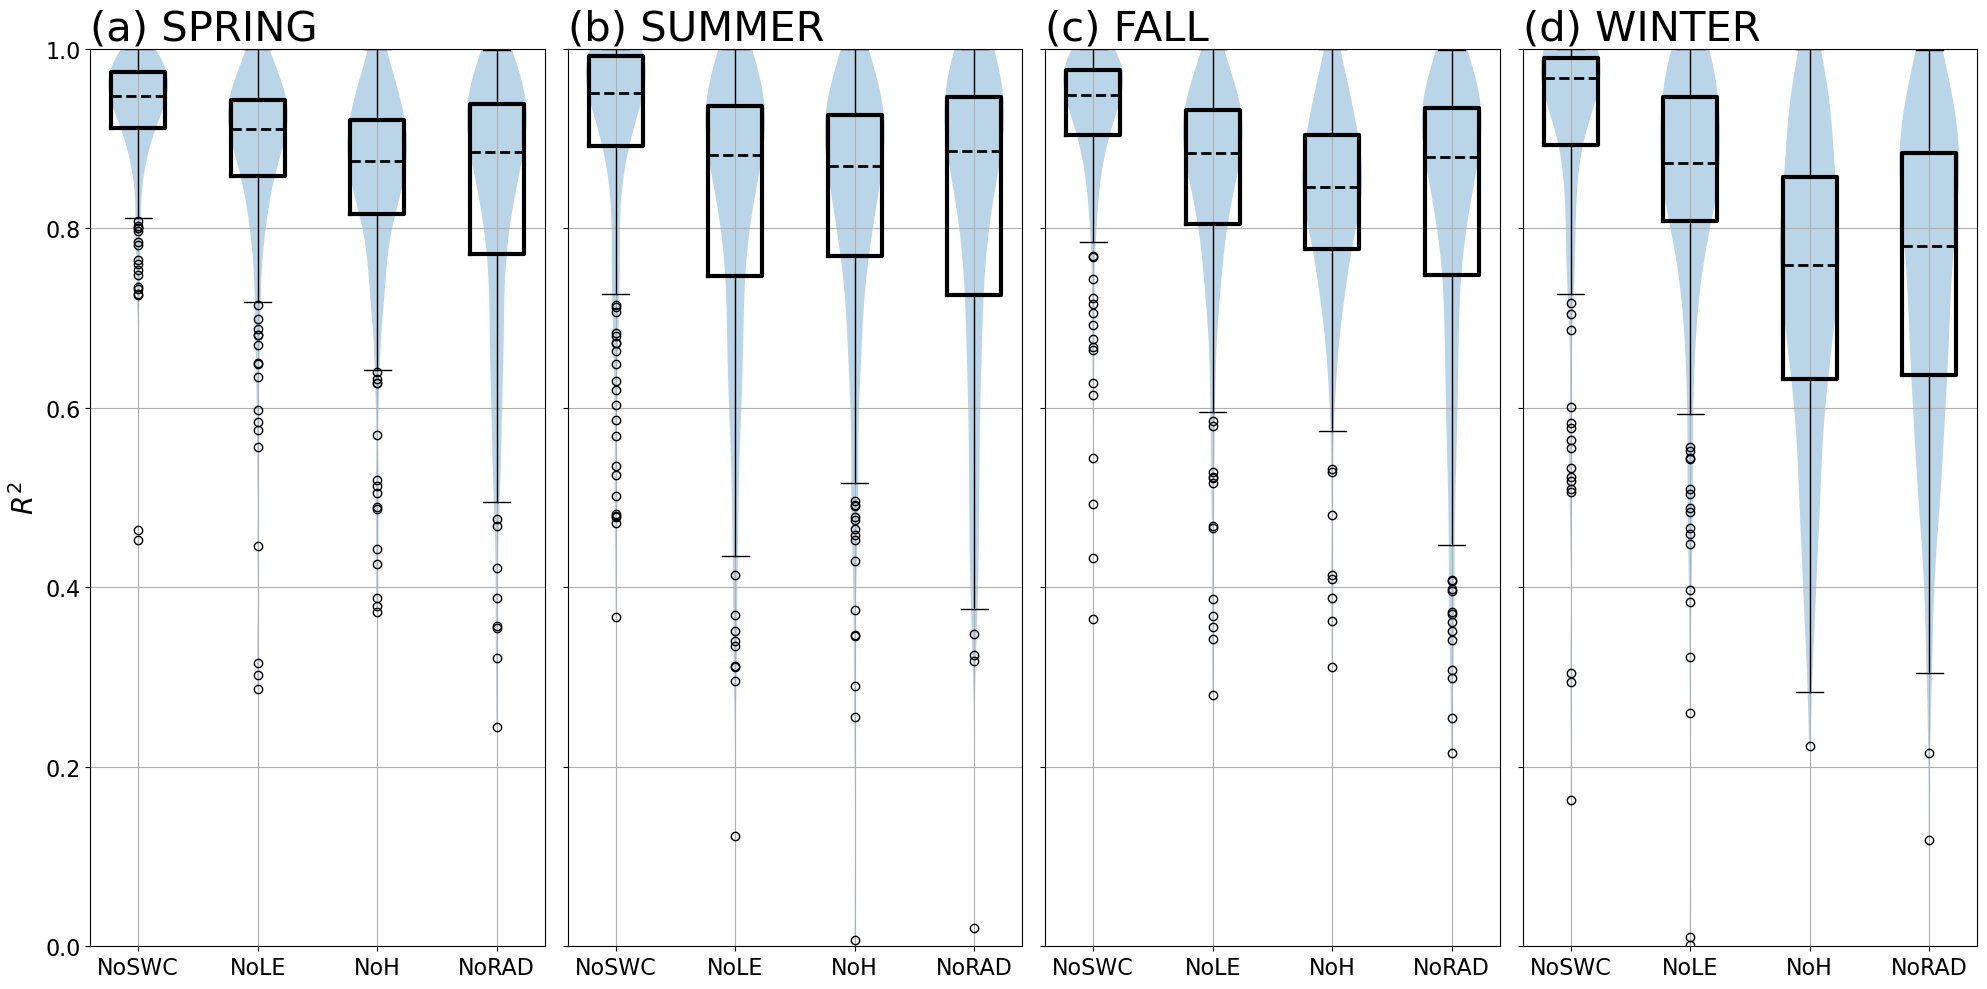

In [11]:
r2_spr = pca_data[seasons[0]]['pc1'].drop(columns=['SiteID']).dropna()
r2_smm = pca_data[seasons[1]]['pc1'].drop(columns=['SiteID']).dropna()
r2_fll = pca_data[seasons[2]]['pc1'].drop(columns=['SiteID']).dropna()
r2_wnt = pca_data[seasons[3]]['pc1'].drop(columns=['SiteID']).dropna()

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 10))
axs[0].violinplot(r2_spr, showextrema=False)
axs[1].violinplot(r2_smm, showextrema=False)
axs[2].violinplot(r2_fll, showextrema=False)
axs[3].violinplot(r2_wnt, showextrema=False)

medianprops = dict(linestyle="--", linewidth=2.0, color="black")
boxprops = dict(linestyle="-", linewidth=3)

axs[0].boxplot(r2_spr, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[1].boxplot(r2_smm, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[2].boxplot(r2_fll, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[3].boxplot(r2_wnt, medianprops=medianprops, boxprops=boxprops, whis=1.7)

ttl = ["(a) SPRING", "(b) SUMMER", "(c) FALL", "(d) WINTER"]

for i in range(0, 4):
    axs[i].yaxis.grid(True)
    axs[i].xaxis.grid(True)
    axs[i].set_xticks([1, 2, 3, 4])
    axs[i].set_xlim(0.6, 4.4)
    axs[i].set_xticklabels(["NoSWC", "NoLE", "NoH", "NoRAD"])
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis="both", which="major", labelsize=16)
    axs[i].set_title(ttl[i], fontsize=30, loc="left")

axs[0].set_ylabel("$R^2$", fontsize=20)

plt.tight_layout()

Figure 2. Distributions of R2 values (y-axis) across stations about surface terms (x-axis) in PC1 from (a) spring, (b) summer, (c) fall, and (d) winter. NoSWC, NoLE, NoH, and NoRAD indicate each surface variable calculated as in Figure 1, respectively. Departures from R2=1 indicate the degree of importance of the missing variable for PC1. Dash lines, boxes, circles, and shading (violin plots) are median values, quartiles, outliers, and probability density functions. The outliers are beyond 3 standard deviations (whiskers). Lighter and darker gray shades on the background indicate the range of R2 thresholds in Figure 3.

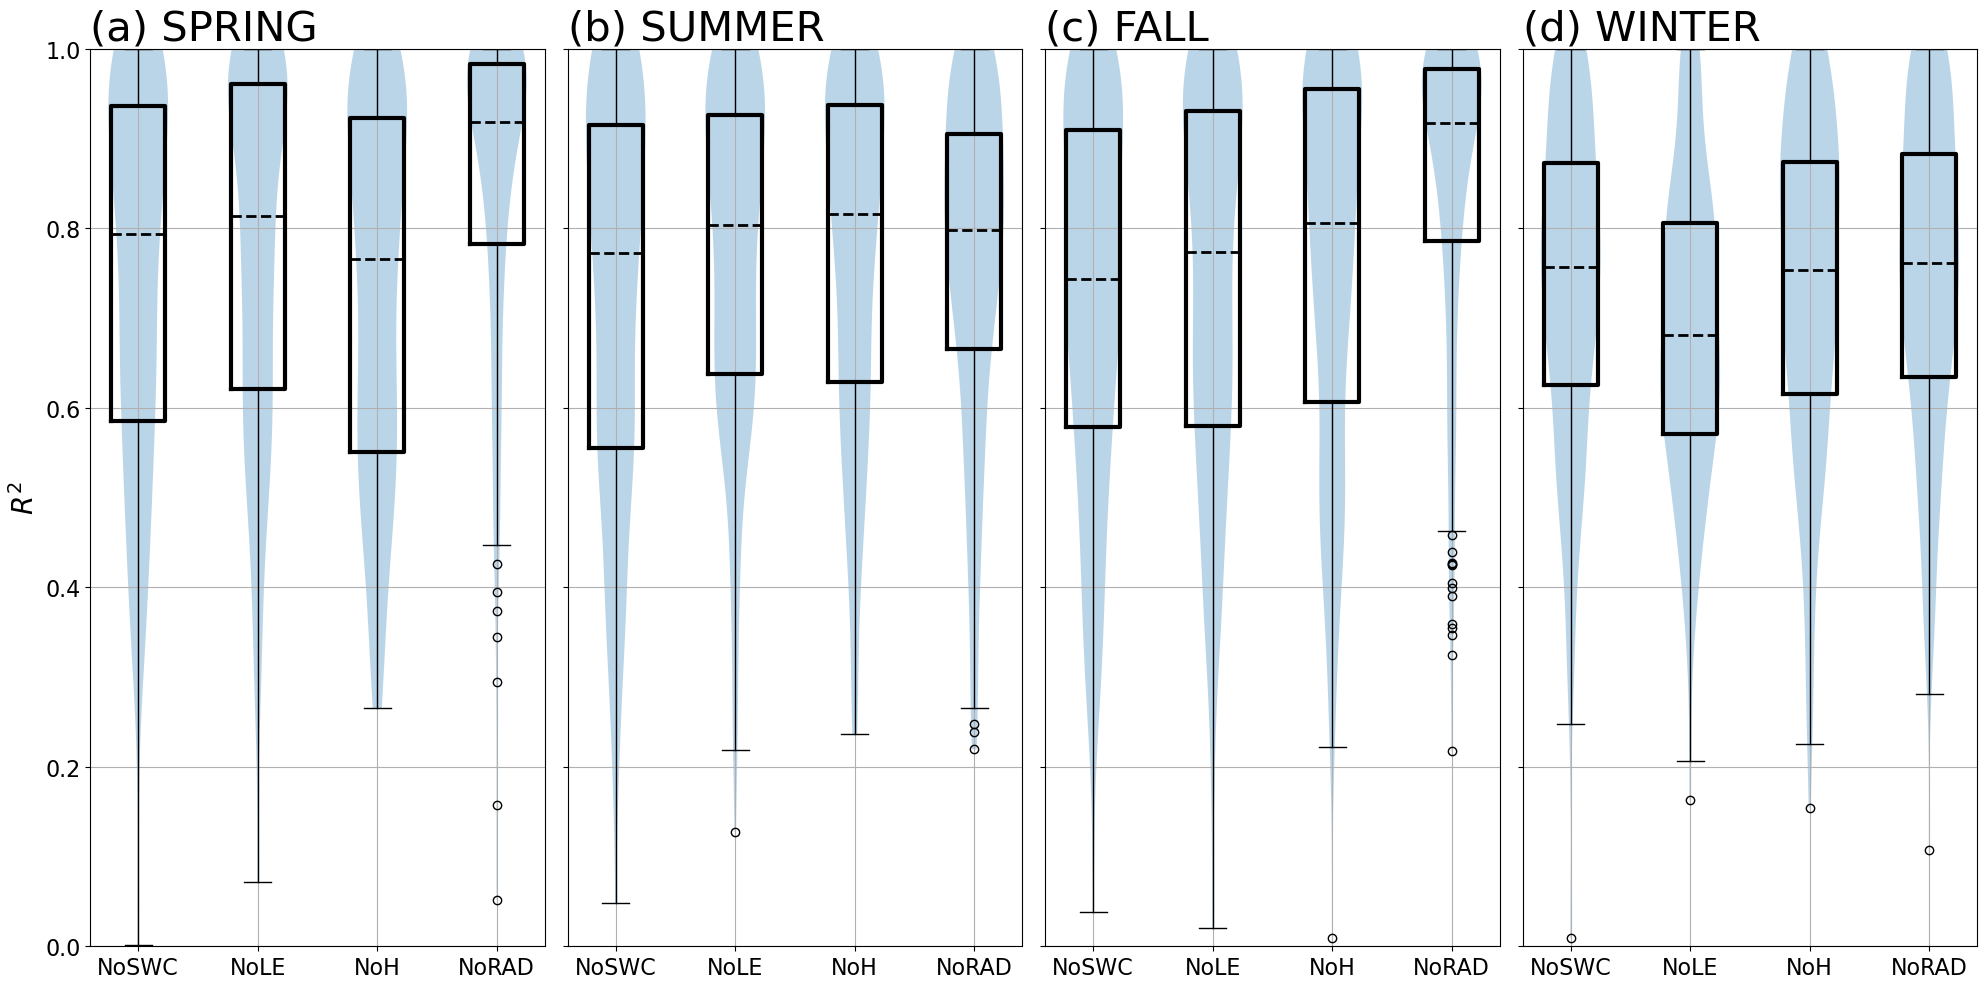

In [12]:
r2_spr2 = pca_data[seasons[0]]['pc2'].drop(columns=['SiteID']).dropna()
r2_smm2 = pca_data[seasons[1]]['pc2'].drop(columns=['SiteID']).dropna()
r2_fll2 = pca_data[seasons[2]]['pc2'].drop(columns=['SiteID']).dropna()
r2_wnt2 = pca_data[seasons[3]]['pc2'].drop(columns=['SiteID']).dropna()

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(20, 10))
axs[0].violinplot(r2_spr2, showextrema=False)
axs[1].violinplot(r2_smm2, showextrema=False)
axs[2].violinplot(r2_fll2, showextrema=False)
axs[3].violinplot(r2_wnt2, showextrema=False)

medianprops = dict(linestyle="--", linewidth=2.0, color="black")
boxprops = dict(linestyle="-", linewidth=3)

axs[0].boxplot(r2_spr2, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[1].boxplot(r2_smm2, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[2].boxplot(r2_fll2, medianprops=medianprops, boxprops=boxprops, whis=1.7)
axs[3].boxplot(r2_wnt2, medianprops=medianprops, boxprops=boxprops, whis=1.7)

ttl = ["(a) SPRING", "(b) SUMMER", "(c) FALL", "(d) WINTER"]

for i in range(0, 4):
    axs[i].yaxis.grid(True)
    axs[i].xaxis.grid(True)
    axs[i].set_xticks([1, 2, 3, 4])
    axs[i].set_xlim(0.6, 4.4)
    axs[i].set_xticklabels(["NoSWC", "NoLE", "NoH", "NoRAD"])
    axs[i].set_ylim(0, 1)
    axs[i].tick_params(axis="both", which="major", labelsize=16)
    axs[i].set_title(ttl[i], fontsize=30, loc="left")

axs[0].set_ylabel("$R^2$", fontsize=20)

plt.tight_layout()

(For revision)
Same as Figure 1 except for PC2.

In [6]:
season_data = {season: {'all': pd.DataFrame(columns=['PC1', 'PC2']),
                        'swc': pd.DataFrame(columns=['PC1', 'PC2']),
                        'le' : pd.DataFrame(columns=['PC1', 'PC2']),
                        'h'  : pd.DataFrame(columns=['PC1', 'PC2']),
                        'rad': pd.DataFrame(columns=['PC1', 'PC2'])} for season in seasons}
for season in seasons:
    for site in site_files[season][:]:  # Limit to first 2 files for now (adjust as needed)
        f_siteid = site.split("/")[-1].split("_")[0]  # Adjust based on actual file structure
        # print(f_siteid)

        # Read data
        df1 = pd.read_csv(dir + f_siteid + f'_PCApct_ALL_{season}_5dys.csv', na_values=-9999)
        df2 = pd.read_csv(dir + f_siteid + f'_PCApct_NoSWC_{season}_5dys.csv', na_values=-9999)
        df3 = pd.read_csv(dir + f_siteid + f'_PCApct_NoLE_{season}_5dys.csv', na_values=-9999)
        df4 = pd.read_csv(dir + f_siteid + f'_PCApct_NoH_{season}_5dys.csv', na_values=-9999)
        df5 = pd.read_csv(dir + f_siteid + f'_PCApct_NoRAD_{season}_5dys.csv', na_values=-9999)

        # Concatenate DataFrames into their respective categories
        season_data[season]['all'] = pd.concat([season_data[season]['all'], df1], ignore_index=True)
        season_data[season]['swc'] = pd.concat([season_data[season]['swc'], df2], ignore_index=True)
        season_data[season]['le']  = pd.concat([season_data[season]['le'] , df3], ignore_index=True)
        season_data[season]['h']   = pd.concat([season_data[season]['h']  , df4], ignore_index=True)
        season_data[season]['rad'] = pd.concat([season_data[season]['rad'], df5], ignore_index=True)

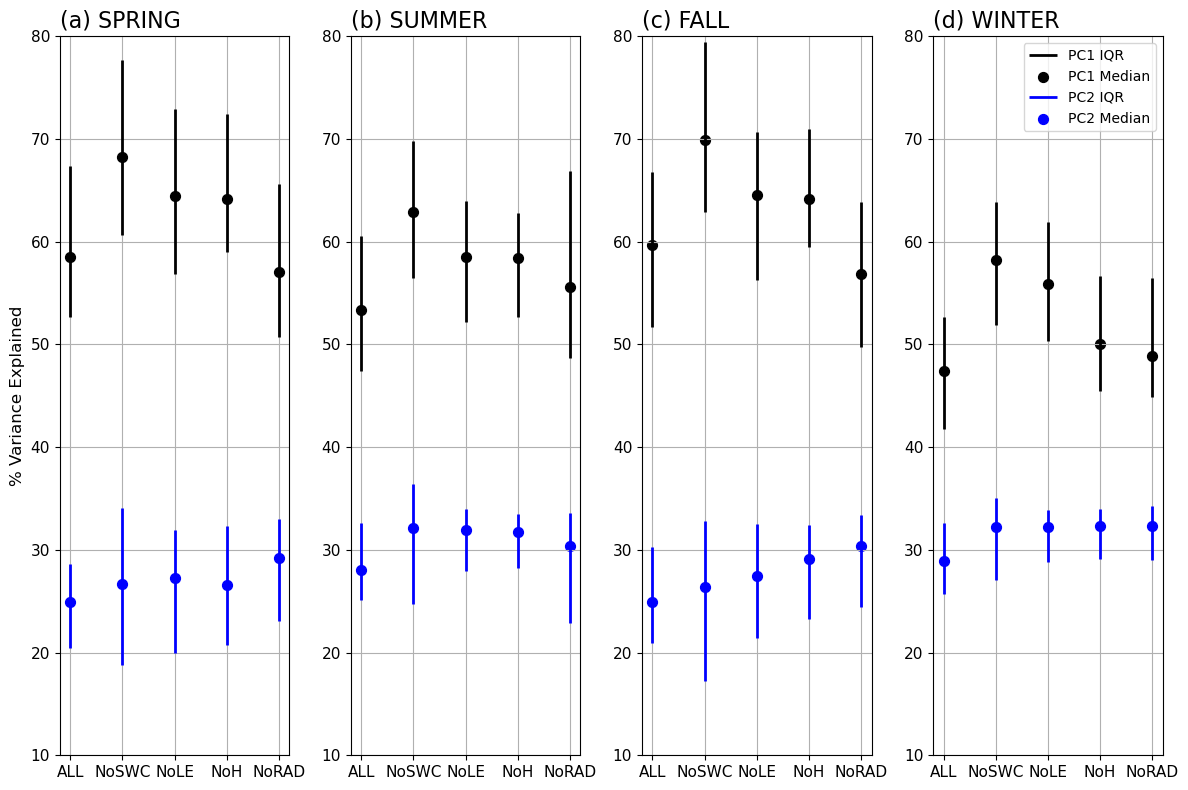

In [9]:
titles = ['(a) SPRING','(b) SUMMER','(c) FALL', '(d) WINTER']
categories = ["ALL", "NoSWC", "NoLE", "NoH", "NoRAD"]  # Labels for each group

fig, axs = plt.subplots(1, 4, figsize=(12, 8))

for i, season in enumerate(seasons):
    ax = axs[i]
    
    pc1_data = []
    pc2_data = []
    
    for cat in ['all', 'swc', 'le', 'h', 'rad']:
        df = season_data[season][cat]
        # PC1, PC2 [%]
        pc1_data.append(df['PC1'].dropna().values * 100)
        pc2_data.append(df['PC2'].dropna().values * 100)

    # PC1, black lines
    for j, data in enumerate(pc1_data):
        Q1 = np.percentile(data, 25)
        Q2 = np.median(data)
        Q3 = np.percentile(data, 75)

        x_pos = j + 1
        ax.vlines(x_pos, Q1, Q3, colors='black', linewidth=2, label="PC1 IQR" if j == 0 else "")
        ax.scatter(x_pos, Q2, color='black', s=50, label="PC1 Median" if j == 0 else "")

    # PC2, blue lines
    for j, data in enumerate(pc2_data):
        Q1 = np.percentile(data, 25)
        Q2 = np.median(data)
        Q3 = np.percentile(data, 75)

        x_pos = j + 1
        ax.vlines(x_pos, Q1, Q3, colors='blue', linewidth=2, label="PC2 IQR" if j == 0 else "")
        ax.scatter(x_pos, Q2, color='blue', s=50, label="PC2 Median" if j == 0 else "")

    ax.set_ylim(10, 80)
    ax.set_xticks(range(1, len(categories) + 1))
    ax.set_xticklabels(categories)
    ax.tick_params(axis="both", which="major", labelsize=11)
    ax.set_title(titles[i], fontsize=16, loc='left')
    ax.yaxis.grid(True)
    ax.xaxis.grid(True)

# Y-axis label and legend
axs[0].set_ylabel("% Variance Explained", fontsize=12)
axs[3].legend(fontsize=10)

plt.tight_layout()
plt.show()


(For revision)

Percentages of PC1 and PC2.


In [17]:
columns = [
    "Site ID",
    "R2[All,NoSWC]",
    "R2[All,NoLE]",
    "R2[All,NoH]",
    "R2[All,NoRad]"
]

pca_data = {
    season: {
        'pc1': pd.DataFrame(columns=columns),
        'pc2': pd.DataFrame(columns=columns)
    }
    for season in seasons
}

In [25]:
df_spr = pca_data[seasons[0]]['pc1']
df_smm = pca_data[seasons[1]]['pc1']
df_fll = pca_data[seasons[2]]['pc1']
df_wnt = pca_data[seasons[3]]['pc1']

In [26]:
df_spr

,SiteID,all_swc,all_le,all_h,all_rad
0,AT-Neu,0.948896,0.859487,0.894887,0.938761
1,AU-ASM,0.797093,0.830052,0.710375,0.927210
2,AU-Ade,0.976129,0.990095,0.962582,0.932548
3,AU-Cpr,0.865111,0.999192,0.946334,0.898742
4,AU-DaP,0.933252,0.974573,0.760571,0.857120
...,...,...,...,...,...
248,US-Whs,0.881857,0.906292,0.372194,0.957044
249,US-Wkg,0.892771,0.972473,0.489853,0.862790
250,US-Wlr,0.816976,0.670318,0.957827,0.553208
251,US-Wrc,0.977622,0.966719,0.918498,0.946252


In [27]:
from scipy.stats import wilcoxon

season_dict = {
    'SPRING': df_spr,
    'SUMMER': df_smm,
    'FALL':   df_fll,
    'WINTER': df_wnt,
}

pairs = [('all_swc', 'all_le'),
         ('all_swc', 'all_h'),
         ('all_swc', 'all_rad'),
         ('all_le' , 'all_h'),
         ('all_le' , 'all_rad'),
         ('all_h'  , 'all_rad'),]

for season, df in season_dict.items():
    print(f"\n--- {season} ---")
    for a, b in pairs:
        # Convert to numeric and align lengths
        a_vals = df[a].apply(pd.to_numeric, errors='coerce')
        b_vals = df[b].apply(pd.to_numeric, errors='coerce')
        paired_df = pd.concat([a_vals, b_vals], axis=1).dropna()
        a_clean = paired_df.iloc[:, 0]
        b_clean = paired_df.iloc[:, 1]

        if len(a_clean) > 0:
            stat, p_val = wilcoxon(a_clean, b_clean)
            print(f"{a} vs {b} | Wilcoxon = {stat:.3f}, p = {p_val:.4f}")
        else:
            print(f"{a} vs {b} | Insufficient data after dropping NaNs")


--- SPRING ---
all_swc vs all_le | Wilcoxon = 6902.000, p = 0.0000
all_swc vs all_h | Wilcoxon = 4422.000, p = 0.0000
all_swc vs all_rad | Wilcoxon = 4092.000, p = 0.0000
all_le vs all_h | Wilcoxon = 9828.000, p = 0.0000
all_le vs all_rad | Wilcoxon = 10050.000, p = 0.0000
all_h vs all_rad | Wilcoxon = 15077.000, p = 0.5937

--- SUMMER ---
all_swc vs all_le | Wilcoxon = 4617.000, p = 0.0000
all_swc vs all_h | Wilcoxon = 5107.000, p = 0.0000
all_swc vs all_rad | Wilcoxon = 7233.000, p = 0.0000
all_le vs all_h | Wilcoxon = 15768.000, p = 0.4979
all_le vs all_rad | Wilcoxon = 16484.000, p = 0.9382
all_h vs all_rad | Wilcoxon = 16281.000, p = 0.8043

--- FALL ---
all_swc vs all_le | Wilcoxon = 6478.000, p = 0.0000
all_swc vs all_h | Wilcoxon = 4520.000, p = 0.0000
all_swc vs all_rad | Wilcoxon = 4871.000, p = 0.0000
all_le vs all_h | Wilcoxon = 11571.000, p = 0.0000
all_le vs all_rad | Wilcoxon = 13804.000, p = 0.0258
all_h vs all_rad | Wilcoxon = 14448.000, p = 0.0917

--- WINTER ---
all

In [28]:
# Collect results here
results = []

for season, df in season_dict.items():
    for a, b in pairs:
        a_vals = df[a].apply(pd.to_numeric, errors='coerce')
        b_vals = df[b].apply(pd.to_numeric, errors='coerce')
        paired_df = pd.concat([a_vals, b_vals], axis=1).dropna()
        a_clean = paired_df.iloc[:, 0]
        b_clean = paired_df.iloc[:, 1]
        
        if len(a_clean) > 0:
            stat, p_val = wilcoxon(a_clean, b_clean)
            results.append({
                'Season': season,
                'Comparison': f"{a} vs {b}",
                't-stat': round(stat, 3),
                'p-value': round(p_val, 4)
            })
        else:
            results.append({
                'Season': season,
                'Comparison': f"{a} vs {b}",
                't-stat': None,
                'p-value': None
            })

# Create final DataFrame
df = pd.DataFrame(results)

# define your mapping from the full R2[…] tokens to the shorthand
mapping = {
    r"R2\[All,NoSWC\]": "NoSWC",
    r"R2\[All,NoLE\]":  "NoLE",
    r"R2\[All,NoH\]":   "NoH",
    r"R2\[All,NoRad\]": "NoRAD",
}

# apply it in one go
df["Comparison"] = df["Comparison"].replace(mapping, regex=True)

# result:
# --- before: "all_swc vs all_le" = "R2[All,NoSWC] vs R2[All,NoLE]"
# --- after:  "NoSWC vs NoLE"
# print(df)


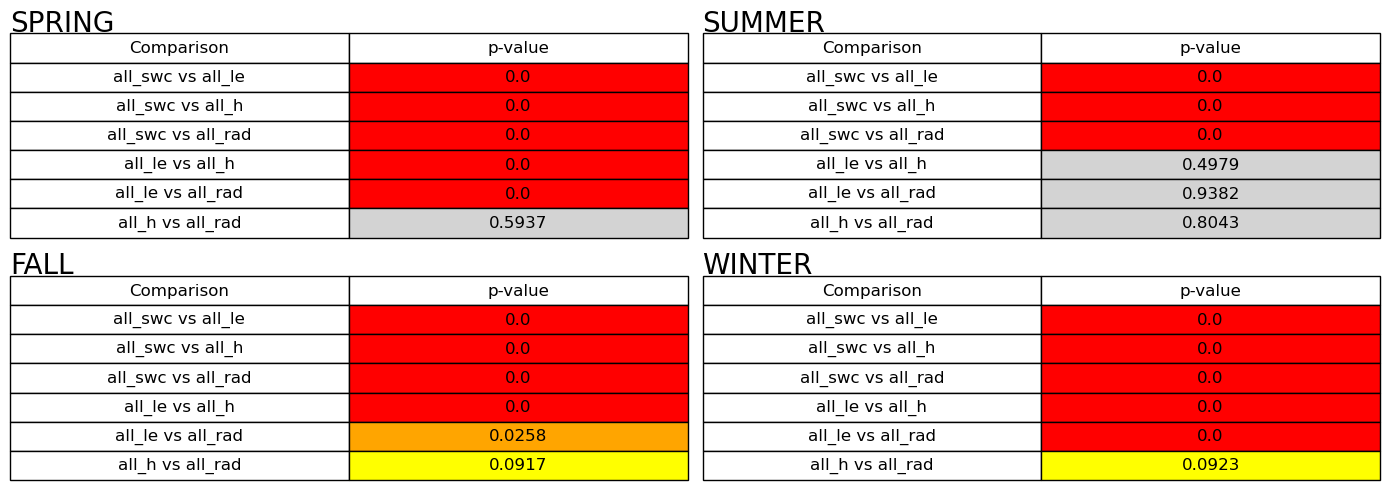

In [30]:
seasons = ["SPRING", "SUMMER", "FALL", "WINTER"]

threshold1 = 0.01
threshold2 = 0.05
threshold3 = 0.1

fig, axes = plt.subplots(2, 2, figsize=(14, 5))
axes = axes.flatten()

for ax, season in zip(axes, seasons):
    df_season = df[df["Season"] == season][["Comparison", "p-value"]].reset_index(drop=True)
    ax.axis('off')
    # Season label on left side
    ax.set_title(season, rotation=0, fontsize=20, loc='left')
    
    # Create table
    table = ax.table(
        cellText=df_season.values,
        colLabels=df_season.columns,
        cellLoc='center',
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.6)
    
    # Highlight p-value cells below threshold
    for row_idx, p_val in enumerate(df_season['p-value']):
        if p_val < threshold1:
            table[(row_idx + 1, 1)].set_facecolor('red')
        elif p_val < threshold2:
            table[(row_idx + 1, 1)].set_facecolor('orange')
        elif p_val < threshold3:
            table[(row_idx + 1, 1)].set_facecolor('yellow')
        else:
            table[(row_idx + 1, 1)].set_facecolor('lightgray')

plt.tight_layout()
plt.show()

(For 2nd Revision)

Significant difference test of nonparametric R2 across seasons. Comparison is conducted among NoSWC,
NoLE, NoH and NoRAD, indicating withholding each surface variable calculated as in Figure 1. Red,
orange, yellow, and gray indicate 99%, 95%, 90%, and non-significant, respectively. Sample sizes across
seasons are 250, 257, 256, 237 in spring, summer, fall, and winter.